https://gluon-ts.mxnet.io/examples/basic_forecasting_tutorial/tutorial.html

In [2]:
# Third-party imports
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

In [3]:
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

In [4]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly']


In [5]:
dataset = get_dataset("m4_hourly", regenerate=False)

INFO:root:using dataset already processed in path C:\Users\vincent_villet\.mxnet\gluon-ts\datasets\m4_hourly.


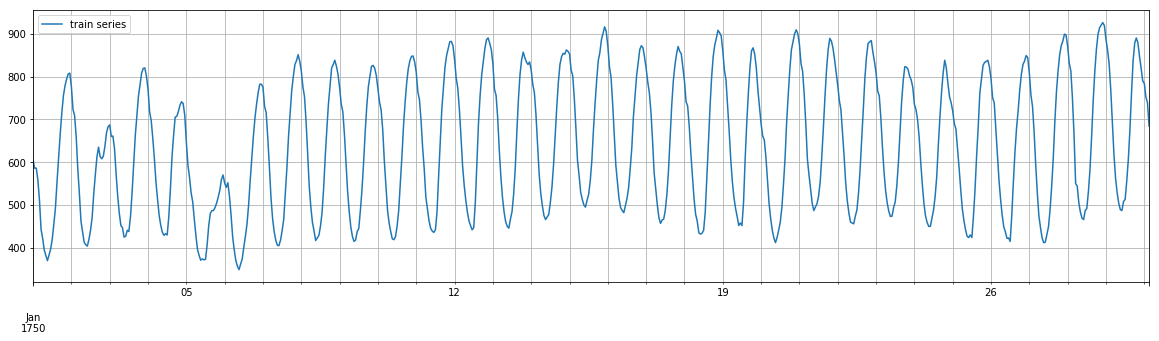

In [6]:
entry = next(iter(dataset.train))
train_series = to_pandas(entry)
plt.figure(1, figsize=(20, 5))
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

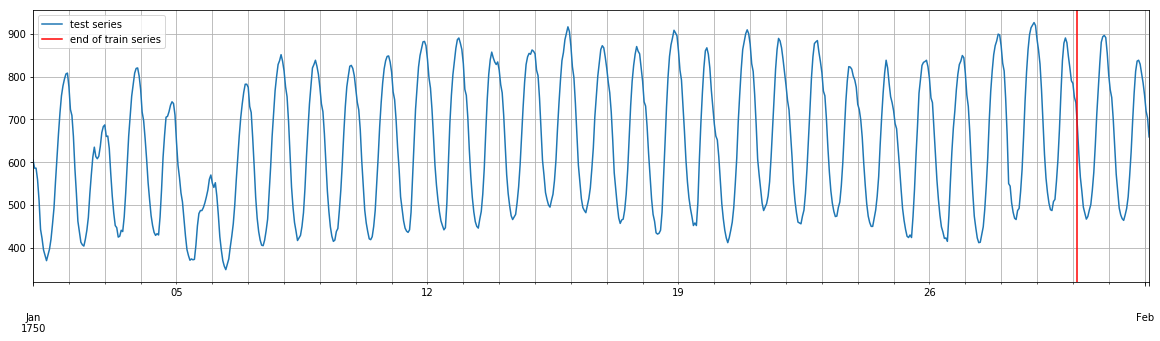

In [7]:
entry = next(iter(dataset.test))
test_series = to_pandas(entry)
plt.figure(1, figsize=(20, 5))
test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.show()

In [8]:
print(f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}")
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Length of forecasting window in test dataset: 48
Recommended prediction horizon: 48
Frequency of the time series: H


In [9]:
N = 10  # number of time series
T = 100  # number of timesteps
prediction_length = 24
freq = "1H"
custom_dataset = np.random.normal(size=(N, T))
start = pd.Timestamp("01-01-2019", freq=freq)  # can be different for each time series

In [10]:
from gluonts.dataset.common import ListDataset

In [11]:
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset([{'target': x, 'start': start}
                        for x in custom_dataset[:, :-prediction_length]],
                       freq=freq)
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset([{'target': x, 'start': start}
                       for x in custom_dataset],
                      freq=freq)



In [12]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.trainer import Trainer

INFO:root:Using CPU


In [13]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=dataset.metadata.prediction_length,
    context_length=100,
    freq=dataset.metadata.freq,
    trainer=Trainer(ctx="cpu",
                    epochs=5,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100
                   )
)

In [14]:
predictor = estimator.train(dataset.train)

INFO:root:Start model training
INFO:root:Number of parameters in SimpleFeedForwardTrainingNetwork: 483
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:01<00:00, 84.75it/s, avg_epoch_loss=5.53]
INFO:root:Epoch[0] Elapsed time 1.186 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=5.534110
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 136.24it/s, avg_epoch_loss=4.72]
INFO:root:Epoch[1] Elapsed time 0.739 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=4.715262
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 127.55it/s, avg_epoch_loss=4.79]
INFO:root:Epoch[2] Elapsed time 0.788 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=4.787180
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 142.05it/s, avg_epoch_loss=4.79]
INFO:root:Epoch[3] Elapsed time 0.709 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=4.791276
INFO:root:Epoch[4] Lea

In [15]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_eval_samples=100,  # number of sample paths we want for evaluation
)

In [16]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [17]:
ts_entry = tss[0]
# first 5 values of the time series (convert from pandas to numpy)
np.array(ts_entry[:5]).reshape(-1,)

array([605., 586., 586., 559., 511.], dtype=float32)

In [18]:
test_list = [test_file for test_file in dataset.test]

In [19]:
len(test_list)

414

In [20]:
# first entry of dataset.test
dataset_test_entry = next(iter(dataset.test))
# first 5 values
dataset_test_entry['target'][:5]

array([605., 586., 586., 559., 511.], dtype=float32)

In [21]:
# first entry of the forecast list
forecast_entry = forecasts[0]

print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")

Number of sample paths: 100
Dimension of samples: (100, 48)
Start date of the forecast window: 1750-01-30 04:00:00
Frequency of the time series: H


In [22]:
len(forecasts)

414

In [23]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

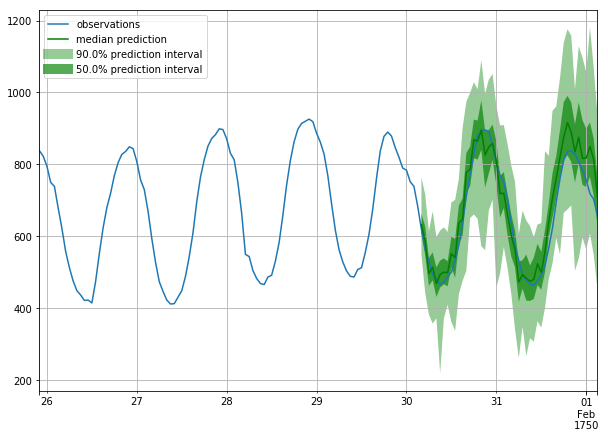

In [24]:
plot_prob_forecasts(ts_entry, forecast_entry)

In [25]:
from gluonts.evaluation import Evaluator


evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))

print(json.dumps(agg_metrics, indent=4))

Running evaluation: 100%|██████████| 414/414 [00:01<00:00, 262.57it/s]


{
    "MSE": 7755885.583872233,
    "abs_error": 9031627.187433243,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043147,
    "seasonal_error": 336.9046924038302,
    "MASE": 3.201874086161539,
    "sMAPE": 0.1836655624887558,
    "MSIS": 36.51908028769129,
    "QuantileLoss[0.1]": 5209758.909132576,
    "Coverage[0.1]": 0.09943639291465386,
    "QuantileLoss[0.5]": 9031627.13242817,
    "Coverage[0.5]": 0.5108695652173915,
    "QuantileLoss[0.9]": 7042126.934598445,
    "Coverage[0.9]": 0.8823470209339773,
    "RMSE": 2784.939062865152,
    "NRMSE": 0.38020569609204347,
    "ND": 0.062047936924519105,
    "wQuantileLoss[0.1]": 0.03579142334789811,
    "wQuantileLoss[0.5]": 0.062047936546630246,
    "wQuantileLoss[0.9]": 0.048379925209977685,
    "mean_wQuantileLoss": 0.048739761701502016,
    "MAE_Coverage": 0.009695383789586768
}


In [26]:
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,sMAPE,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,NaN,3601.315104,1876.863525,31644.0,659.250000,42.371302,0.922826,0.057404,6.016044,985.053796,0.000000,1876.863464,0.791667,1462.059534,1.000000
1,NaN,140933.968750,16903.644531,124149.0,2586.437500,165.107988,2.132903,0.130690,9.897945,3196.098047,0.208333,16903.645142,1.000000,8529.405908,1.000000
2,NaN,31904.070312,6721.336426,65030.0,1354.791667,78.889053,1.774997,0.099361,11.248152,3579.991528,0.000000,6721.336426,0.145833,2014.803027,0.729167
3,NaN,300986.125000,19591.394531,235783.0,4912.145833,258.982249,1.575992,0.080119,7.024043,9466.858545,0.020833,19591.393555,0.375000,7591.467090,1.000000
4,NaN,86717.364583,11149.751953,131088.0,2731.000000,200.494083,1.158570,0.080201,6.180880,4494.761743,0.020833,11149.751465,0.645833,7269.840283,1.000000


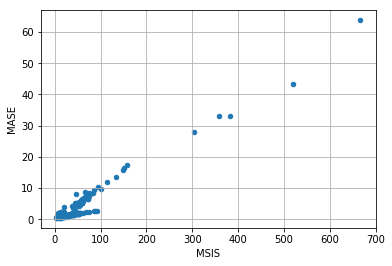

In [27]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()

# Création de modèles gluon custom

In [28]:
class MyTrainNetwork(gluon.HybridBlock):
    def __init__(self, prediction_length, **kwargs):
        super().__init__(**kwargs)
        self.prediction_length = prediction_length

        with self.name_scope():
            # Set up a 3 layer neural network that directly predicts the target values
            self.nn = mx.gluon.nn.HybridSequential()
            self.nn.add(mx.gluon.nn.Dense(units=40, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=40, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=self.prediction_length, activation='softrelu'))

    def hybrid_forward(self, F, past_target, future_target):
        prediction = self.nn(past_target)
        # calculate L1 loss with the future_target to learn the median
        return (prediction - future_target).abs().mean(axis=-1)


class MyPredNetwork(MyTrainNetwork):
    # The prediction network only receives past_target and returns predictions
    def hybrid_forward(self, F, past_target):
        prediction = self.nn(past_target)
        return prediction.expand_dims(axis=1)

In [29]:
from gluonts.model.estimator import GluonEstimator
from gluonts.model.predictor import Predictor, RepresentableBlockPredictor
from gluonts.core.component import validated
from gluonts.support.util import copy_parameters
from gluonts.transform import ExpectedNumInstanceSampler, Transformation, InstanceSplitter, FieldName
from mxnet.gluon import HybridBlock

In [30]:
class MyEstimator(GluonEstimator):
    @validated()
    def __init__(
        self,
        freq: str,
        context_length: int,
        prediction_length: int,
        trainer: Trainer = Trainer()
    ) -> None:
        super().__init__(trainer=trainer)
        self.context_length = context_length
        self.prediction_length = prediction_length
        self.freq = freq


    def create_transformation(self):
        # Feature transformation that the model uses for input.
        # Here we use a transformation that randomly select training samples from all time series.
        return InstanceSplitter(
                    target_field=FieldName.TARGET,
                    is_pad_field=FieldName.IS_PAD,
                    start_field=FieldName.START,
                    forecast_start_field=FieldName.FORECAST_START,
                    train_sampler=ExpectedNumInstanceSampler(num_instances=1),
                    past_length=self.context_length,
                    future_length=self.prediction_length,
                )

    def create_training_network(self) -> MyTrainNetwork:
        return MyTrainNetwork(
            prediction_length=self.prediction_length
        )

    def create_predictor(
        self, transformation: Transformation, trained_network: HybridBlock
    ) -> Predictor:
        prediction_network = MyPredNetwork(
            prediction_length=self.prediction_length
        )

        copy_parameters(trained_network, prediction_network)

        return RepresentableBlockPredictor(
            input_transform=transformation,
            prediction_net=prediction_network,
            batch_size=self.trainer.batch_size,
            freq=self.freq,
            prediction_length=self.prediction_length,
            ctx=self.trainer.ctx,
        )

INFO:root:Using CPU


In [31]:
estimator = MyEstimator(
    prediction_length=dataset.metadata.prediction_length,
    context_length=100,
    freq=dataset.metadata.freq,
    trainer=Trainer(ctx="cpu",
                    epochs=5,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100
                   )
)

In [32]:
predictor = estimator.train(dataset.train)

INFO:root:Start model training
INFO:root:Number of parameters in MyTrainNetwork: 128
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 146.41it/s, avg_epoch_loss=2.4e+3]
INFO:root:Epoch[0] Elapsed time 0.687 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=2403.802630
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 147.59it/s, avg_epoch_loss=880]
INFO:root:Epoch[1] Elapsed time 0.682 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=880.235684
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 130.72it/s, avg_epoch_loss=766]
INFO:root:Epoch[2] Elapsed time 0.770 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=765.937342
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:00<00:00, 105.71it/s, avg_epoch_loss=617]
INFO:root:Epoch[3] Elapsed time 0.951 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=616.593228
INFO:root:Epoch[4] Learning rat

In [33]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor,
    num_eval_samples=100
)

In [34]:
forecasts = list(forecast_it)
tss = list(ts_it)

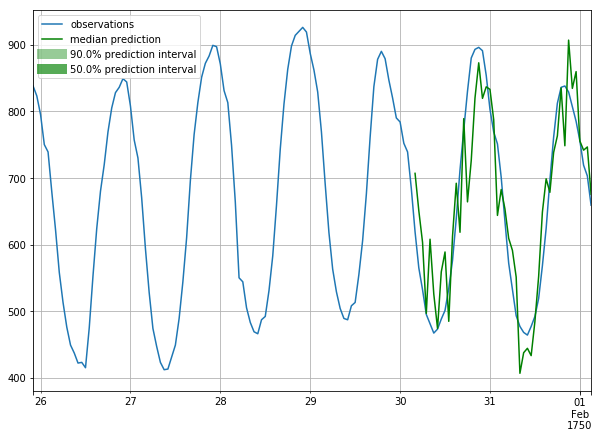

In [35]:
plot_prob_forecasts(tss[0], forecasts[0])

In [36]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))

Running evaluation: 100%|██████████| 414/414 [00:01<00:00, 244.81it/s]


In [37]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 8273970.940853818,
    "abs_error": 10216699.555835724,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043147,
    "seasonal_error": 336.9046924038302,
    "MASE": 4.6870137388820465,
    "sMAPE": 0.2302464901022601,
    "MSIS": 187.48054983359359,
    "QuantileLoss[0.1]": 12665496.7640584,
    "Coverage[0.1]": 0.4922000805152986,
    "QuantileLoss[0.5]": 10216699.555552006,
    "Coverage[0.5]": 0.4922000805152986,
    "QuantileLoss[0.9]": 7767902.3470456125,
    "Coverage[0.9]": 0.4922000805152986,
    "RMSE": 2876.4511017665186,
    "NRMSE": 0.392699110729095,
    "ND": 0.07018947045326576,
    "wQuantileLoss[0.1]": 0.08701288572091043,
    "wQuantileLoss[0.5]": 0.0701894704513166,
    "wQuantileLoss[0.9]": 0.05336605518172278,
    "mean_wQuantileLoss": 0.0701894704513166,
    "MAE_Coverage": 0.2692666398282338
}
